## KAGGLE(LOAD FILES)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/drug-interaction-and-smiles/interaction_list.csv
/kaggle/input/drug-interaction-and-smiles/drugIDandSMILES.csv


## COLAB(UPLOADING FILES)

In [ ]:
## UPLOAD THE TWO FILES
from google.colab import files
uploaded = files.upload()

Saving drugIDandSMILES.csv to drugIDandSMILES.csv
Saving interaction_list.csv to interaction_list.csv


## Installing the packages



In [ ]:
! pip install rdkit-pypi
! pip install deepchem
# ! pip install dgl 
! pip install ogb

     |████████████████████████████████| 19.7 MB 27.3 MB/s 
     |████████████████████████████████| 552 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 1.1 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=d4c8861ceeed23a4eb469830fc3a73c288541e6148f29e1f8099bf856b3b29d9
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 164.7 MB 11 kB/s 


## Importing the required modules

In [ ]:
import numpy as np
import pandas
import time
import networkx as nx
import itertools
import scipy.sparse as sp
import random 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

In [ ]:
import dgl
from dgl.nn import SAGEConv,GraphConv
import dgl.function as fn

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
from sklearn.metrics import roc_auc_score
from ogb.linkproppred import Evaluator

In [ ]:
import copy

## Reading the files and saving the required columns in variables





In [ ]:
csvFile = pandas.read_csv('./drugIDandSMILES.csv')
 
print(len(csvFile))
print(csvFile)

11160
       Drug ID                                             SMILES
0      DB00006  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
1      DB00007  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...
2      DB00014  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
3      DB00027  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
4      DB00035  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...
...        ...                                                ...
11155  DB16400  [H][C@@]1(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O)...
11156  DB16403  [H][C@@]1(O[C@@H](OC2=C(OC3=C(C(O)=CC(O)=C3)C2...
11157  DB16404                             CC(C)C1=CC(O)=C(C)C=C1
11158  DB16406  CC1=C(C=C(S1)C(=O)C1=C(N[C@H]2C[C@H](O)[C@@H](...
11159  DB16408  COC1=NC(OC)=C2C(O[C@]3([C@@H]([C@@H](CN(C)C)[C...

[11160 rows x 2 columns]


In [ ]:
drug_id = csvFile['Drug ID']
smiles = csvFile['SMILES']

In [ ]:
csvFile = pandas.read_csv('./interaction_list.csv')
 
print(len(csvFile))
print(csvFile)

658269
       Drug1 ID Drug2 ID
0       DB00001  DB01323
1       DB00001  DB00346
2       DB00001  DB13783
3       DB00001  DB06605
4       DB00001  DB09075
...         ...      ...
658264  DB13929  DB12749
658265  DB13929  DB12771
658266  DB13929  DB13036
658267  DB13929  DB13400
658268  DB13929  DB13510

[658269 rows x 2 columns]


In [ ]:
interaction_id1 = csvFile['Drug1 ID']
interaction_id2 = csvFile['Drug2 ID']

In [ ]:
# print(smiles[0])

## Checking the USE of MACCS keys for encoding the SMILES 

In [ ]:
# # Paper on MACCS keys: https://www.biorxiv.org/content/10.1101/853762v1.full.pdf

# molecular access system : (MACCS)

# MACCS keys are 166-bit 2D structure fingerprints that are commonly used for the 
# measure of molecular similarity. Because each bit is either on (i.e., 1) or 
# off (i.e., 0), MACCS 166 keys can represent more than 9.3 × 1049 distinct 
# fingerprint vectors

# CODE LINK: https://github.com/rdkit/rdkit-orig/blob/master/rdkit/Chem/MACCSkeys.py
# help(MACCSkeys.GenMACCSKeys)

In [ ]:
# CHECKING THE MACCS ENCODINGS OF DIFFERENT MOLECULES

mol = Chem.MolFromSmiles(smiles[0])
# print(MACCSkeys.GenMACCSKeys(mol)) --> rdkit.DataStructs.cDataStructs.ExplicitBitVect object
print(list(MACCSkeys.GenMACCSKeys(mol)))
print(len(list(MACCSkeys.GenMACCSKeys(mol))))

mol2 = Chem.MolFromSmiles(smiles[1])
print(list(MACCSkeys.GenMACCSKeys(mol2)))
print(len(list(MACCSkeys.GenMACCSKeys(mol2))))

mol3 = Chem.MolFromSmiles(smiles[2])
print(list(MACCSkeys.GenMACCSKeys(mol3)))
print(len(list(MACCSkeys.GenMACCSKeys(mol3))))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
167
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# print(smiles[0])
# print(list(smiles[0]))
# x=[]
# x.append(smiles[0])
# print(x)

## Common variable(s) and function(s) for all models

In [ ]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## FORMING THE GRAPH USING THE INTERACTIONS AS EDGES AND ENCODING THE SMILES AS FEATURES FOR THE NODES

In [ ]:
drugbank_id_to_graph_node_id_map = {}
graph_node_id_to_drugbank_id_map = {}

drugs_with_smiles_list = set()

# to maintain the count of nodes in the graph
count = 0 

for x in drug_id:
#     print(x)
    drugbank_id_to_graph_node_id_map[x] = count
    graph_node_id_to_drugbank_id_map[count] = x
    drugs_with_smiles_list.add(x)
    count = count + 1
#     break

In [ ]:
print(len(drugbank_id_to_graph_node_id_map))
print(len(graph_node_id_to_drugbank_id_map))
print(len(drugs_with_smiles_list))
print(len(smiles))

11160
11160
11160
11160


In [ ]:
%%time 
# For the drugs_with_smiles_list, using the set(set()) inplace of list([])
# reduces the time consumed from 2 min 9 sec to 10.9 sec
num_interactions = len(interaction_id1)
# print(num_interactions)
u = []
v = []
for i in range(num_interactions):
    if interaction_id1[i] in drugs_with_smiles_list and interaction_id2[i] in drugs_with_smiles_list:
#         print(interaction_id1[i], interaction_id2[i])
#         break
        u.append(drugbank_id_to_graph_node_id_map[interaction_id1[i]])
        v.append(drugbank_id_to_graph_node_id_map[interaction_id2[i]])

CPU times: user 8.82 s, sys: 12.3 ms, total: 8.83 s
Wall time: 9.19 s


In [ ]:
print(len(interaction_id1))
print(len(u))
print(len(v))

658269
583548
583548


In [ ]:
print(len(drugs_with_smiles_list))
no_nodes = len(drugs_with_smiles_list)

11160


In [ ]:
g = dgl.DGLGraph()
g.add_nodes(no_nodes)

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [ ]:
g.add_edges(u,v)

In [ ]:
print(g)
print(u[0], v[0])
for t1,t2 in zip(u,v):
  if t1 == v[0] and t2 == u[0]:
    print(t1,t2)
    print("found")
    break

Graph(num_nodes=11160, num_edges=583548,
      ndata_schemes={}
      edata_schemes={})
0 240
240 0
found


In [ ]:
%%time
# to find out if there are unidirectional edges(and, the edges themselves)
edges_as_set = set()
new_edges_to_be_added = 0
for _ in zip(u,v):
  edges_as_set.add(_)
for (t2,t1) in zip(v,u):
  flag = 0
  if (t2,t1) not in edges_as_set:
    print(t2,t1)
    # g.add_edges([t2],[t1])
    new_edges_to_be_added+=1
    ## REMOVE THE break STATEMENT NEXT LINE TO FIND TOTAL EDGES TO BE ADDED
    break

# print(new_edges_to_be_added)

# A more time consuming approach for the same task
# index_count = 0
# new_edges_added = 0
# for t1,t2 in zip(u,v):
#   flag = 0
#   for t3,t4 in zip(u,v):
#     if t3 == t2 and t4 == t1:
#       flag =1
#       break
#   if flag == 0:
#     g.add_edges([t2],[t1])
#     new_edges_added+=1

# print(new_edges_added)

7815 0
CPU times: user 147 ms, sys: 19.1 ms, total: 166 ms
Wall time: 166 ms


In [ ]:
# MAKING THE GRAPH A BIDIRECTIONAL ONE BY ADDING REVERSE EDGES 
# # g.add_edges(v,u)
print(g.num_edges())
print(g.num_nodes())
n1 = g.num_edges()
g = dgl.add_reverse_edges(g)
n2 = g.num_edges()
print(n2/n1)
print(g.num_edges())
print(g.num_nodes())

583548
11160
2.0
1167096
11160


In [ ]:
# CHECK A FEW EDGES TO VERIFY THAT THE EDGES ARE EXTRACTED 
# PROPERLY FROM THE CSV FILE TO THE DGL GRAPH
print(u[0], v[0])
# print(v[0])
print(u[1], v[1])
print(graph_node_id_to_drugbank_id_map[u[0]], graph_node_id_to_drugbank_id_map[v[0]])
print(graph_node_id_to_drugbank_id_map[u[1]], graph_node_id_to_drugbank_id_map[v[1]])
temp_count = 0
for i in range(num_interactions):
    if interaction_id1[i] in drugs_with_smiles_list and interaction_id2[i] in drugs_with_smiles_list:
        print(interaction_id1[i], interaction_id2[i])
        temp_count = temp_count + 1
        if temp_count == 2:
            break

0 240
0 9715
DB00006 DB00346
DB00006 DB13783
DB00006 DB00346
DB00006 DB13783


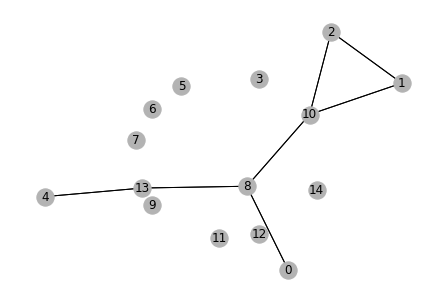

In [ ]:
# Extract a sub graph and view it
sg1 = g.subgraph([0,1,2,3,4,5,6,7,8,9,10,15,67,89,90])
# using networkx to view it 
# Since the actual graph is undirected, we convert it for visualization purpose
nx_G = sg1.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
# from rdkit.Chem import MACCSkeys
# from rdkit import Chem

mol = Chem.MolFromSmiles(smiles[0])
print(list(MACCSkeys.GenMACCSKeys(mol)))
MACCSkeys_length = len(list(MACCSkeys.GenMACCSKeys(mol)))
print(MACCSkeys_length)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
167


In [ ]:
# tensor1 = torch.zeros(3,3)
# print(tensor1[0])
# tensor1[0] = torch.Tensor([1,2,3])
# print(tensor1)

In [ ]:
%%time
# LIST TO CAPTURE THE MOLECULES THAT ARE NOT BEING ABLE TO ENCODED AS MACCS_KEYS
molecules_with_no_MACCS_keys = []
MACCSkeys_features = torch.zeros(g.num_nodes(), MACCSkeys_length)
for i in range(g.num_nodes()):
    mol = Chem.MolFromSmiles(smiles[i])
    try:
        MACCSkeys__ = list(MACCSkeys.GenMACCSKeys(mol))
        MACCSkeys_features[i] = torch.Tensor(MACCSkeys__)
    except:
        print(drug_id[i])
        molecules_with_no_MACCS_keys.append(drug_id[i])

DB00515
DB00526
DB00958
DB01999
DB11630
DB13145
CPU times: user 15 s, sys: 581 ms, total: 15.6 s
Wall time: 15.5 s


In [ ]:
g.ndata['feat'] = MACCSkeys_features

In [ ]:
# If you don't add self loops for all the nodes, atleast do it 
# for the last node, to maintain parity in dimensions. 
# For the last node, there is no edge arising from it for the interactions, 
# and, hence, it goes missing, in the nodes with edges list. 
# print(g.num_edges())
# g.add_edges([no_nodes-1],[no_nodes-1])
# print(g.num_edges())

In [ ]:
# ADDING SELF LOOPS FOR EACH OF THE NODES 
# TO ENSURE THAT THE FEATURES ARE NOT LOST FOR THE NODES WITH NO EDGES 
# ARISING OUT OF IT
print(g)
n1 = g.num_edges()
l1 = [i for i in range(no_nodes)]
g.add_edges(l1,l1)
# for i in range(no_nodes):
#   g.add_edge([i], [i])
n2 = g.num_edges()
print(n2 - n1)
print(g)

Graph(num_nodes=11160, num_edges=1167096,
      ndata_schemes={'feat': Scheme(shape=(167,), dtype=torch.float32)}
      edata_schemes={})
11160
Graph(num_nodes=11160, num_edges=1178256,
      ndata_schemes={'feat': Scheme(shape=(167,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
# g = g.to(device)

## Training, Evaluation and Testing sets in the ratio of 70:10:20

In [ ]:
u, v = g.edges()

print(len(u))

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.2)
val_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size - val_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size:(test_size+val_size)]], v[eids[test_size:(test_size+val_size)]]
train_pos_u, train_pos_v = u[eids[(test_size+val_size):]], v[eids[(test_size+val_size):]]

print(test_size, val_size, train_size)
print(len(test_pos_u), len(test_pos_v))
print(len(val_pos_u), len(val_pos_v))
print(len(train_pos_u), len(train_pos_v))

1178256
235651 117825 824780
235651 235651
117825 117825
824780 824780


In [ ]:
# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
print(adj.shape)
adj_dense = adj.todense()
adj_dense = np.clip(adj_dense, a_min = 0, a_max = 1)

(11160, 11160)


In [ ]:
# REMOVE THE DUPLICATE EDGES
# SINCE SELF LOOPS ARE ADDED, TO CREATE THE adj_neg, WE NO LONGER NEED 
# TO SUBTRACT THE np.eye(g.num_nodes()) in the next STATEMENT
# adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
adj_neg = 1 - adj_dense 
print(np.where(adj_dense>1))
print(np.where(adj_neg<0))
print(np.where(adj_neg>1))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [ ]:
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size:(test_size + val_size)]], neg_v[neg_eids[test_size:(test_size + val_size)]]
train_neg_u, train_neg_v = neg_u[neg_eids[(test_size + val_size):(test_size + val_size+ train_size)]], neg_v[neg_eids[(test_size + val_size):(test_size + val_size+ train_size)]]


In [ ]:
train_g = dgl.remove_edges(g, eids[:(test_size+val_size)])

In [ ]:
train_g = train_g.to(device)

In [ ]:
# adding self loops 
# (THIS PROCESS IS REDUNDANT, for the nodes in train_g that
# already have self loops, and hence, it introduces duplicacies)

# print(train_g)
# new_train_g_with_self_loops = dgl.add_self_loop(train_g)
# print(new_train_g_with_self_loops)
# print(new_train_g_with_self_loops.num_edges() - train_g.num_edges())

## MODEL: Preliminary GRAPHSAGE, METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        


In epoch 0, loss: 10.995, val_auc: 0.705, best_val_auc: 0.705
In epoch 5, loss: 0.730, val_auc: 0.663, best_val_auc: 0.793
In epoch 10, loss: 0.697, val_auc: 0.785, best_val_auc: 0.793
In epoch 15, loss: 0.693, val_auc: 0.686, best_val_auc: 0.793
In epoch 20, loss: 0.693, val_auc: 0.510, best_val_auc: 0.793
In epoch 25, loss: 0.693, val_auc: 0.445, best_val_auc: 0.793
In epoch 30, loss: 0.693, val_auc: 0.456, best_val_auc: 0.793
In epoch 35, loss: 0.693, val_auc: 0.517, best_val_auc: 0.793
In epoch 40, loss: 0.692, val_auc: 0.638, best_val_auc: 0.793
In epoch 45, loss: 0.690, val_auc: 0.737, best_val_auc: 0.793
In epoch 50, loss: 0.679, val_auc: 0.846, best_val_auc: 0.846
In epoch 55, loss: 0.661, val_auc: 0.884, best_val_auc: 0.889
In epoch 60, loss: 0.629, val_auc: 0.904, best_val_auc: 0.904
In epoch 65, loss: 0.597, val_auc: 0.909, best_val_auc: 0.909
In epoch 70, loss: 0.575, val_auc: 0.925, best_val_auc: 0.927
In epoch 75, loss: 0.560, val_auc: 0.938, best_val_auc: 0.938
In epoch 

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9774693014192367


### VIEWING HITS@10, HITS@20, HITS@30 METRICS ON THE RESULT

In [ ]:
# https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi
# https://github.com/CUAI/Edge-Proposal-Sets/blob/master/train_and_eval.py#L96

pos_valid_pred = pred(val_pos_g, h)
neg_valid_pred = pred(val_neg_g, h)
# val_auc = compute_auc(pos_score, neg_score)
pos_test_pred = pred(test_pos_g, h)
neg_test_pred = pred(test_neg_g, h)
# test_auc = compute_auc(pos_score, neg_score)

evaluator = Evaluator(name='ogbl-ddi')
hits = {
    "ddi": [10,20,30],
}

results = {}
with torch.no_grad():
    for K in hits["ddi"]:
        evaluator.K = K
        # train_hits = evaluator.eval({
        #     'y_pred_pos': pos_train_pred,
        #     'y_pred_neg': neg_valid_pred,
        # })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)
    print(results)

{'Hits@10': (2.5461489497135583e-05, 2.121781787473849e-05), 'Hits@20': (6.789730532569488e-05, 3.3948508599581586e-05), 'Hits@30': (9.335879482283047e-05, 3.819207217452928e-05)}


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

def compute_hits_k2(pos_score, neg_score, K):
    with torch.no_grad():
        evaluator = Evaluator(name='ogbl-ddi')
        evaluator.K = K
        hits = evaluator.eval({
                'y_pred_pos': pos_score,
                'y_pred_neg': neg_score,
            })[f'hits@{K}']
        return hits

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))

In epoch 0, loss: 14.996, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.924, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 10, loss: 0.694, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 15, loss: 0.692, val_hits_k: 0.000008, best_val_hits_k: 0.000008
In epoch 20, loss: 0.693, val_hits_k: 0.000025, best_val_hits_k: 0.000025
In epoch 25, loss: 0.693, val_hits_k: 0.000042, best_val_hits_k: 0.000042
In epoch 30, loss: 0.693, val_hits_k: 0.000059, best_val_hits_k: 0.000059
In epoch 35, loss: 0.693, val_hits_k: 0.000059, best_val_hits_k: 0.000059
In epoch 40, loss: 0.693, val_hits_k: 0.000059, best_val_hits_k: 0.000059
In epoch 45, loss: 0.693, val_hits_k: 0.000051, best_val_hits_k: 0.000059
In epoch 50, loss: 0.693, val_hits_k: 0.000042, best_val_hits_k: 0.000059
In epoch 55, loss: 0.693, val_hits_k: 0.000042, best_val_hits_k: 0.000059
In epoch 60, loss: 0.693, val_hits_k: 0.000042, best_val_hits_k: 0.000059
In epoch 65, loss: 0.693, val_hits_k: 0

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

5.9409890049267774e-05


In [ ]:
y_pred_neg = neg_score
y_pred_pos = pos_score
K = 20
if len(y_pred_neg) < K:
    hitsK = {'hits@{}'.format(K): 1.}

kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)

print(hitsK)

5.9409890049267774e-05


## MODEL: GRAPHSAGE **(Optmized the setup)**, METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 20.319, val_auc: 0.773, best_val_auc: 0.773
In epoch 5, loss: 0.721, val_auc: 0.746, best_val_auc: 0.773
In epoch 10, loss: 0.683, val_auc: 0.834, best_val_auc: 0.834
In epoch 15, loss: 0.652, val_auc: 0.888, best_val_auc: 0.888
In epoch 20, loss: 0.621, val_auc: 0.906, best_val_auc: 0.906
In epoch 25, loss: 0.605, val_auc: 0.917, best_val_auc: 0.917
In epoch 30, loss: 0.582, val_auc: 0.921, best_val_auc: 0.921
In epoch 35, loss: 0.563, val_auc: 0.926, best_val_auc: 0.926
In epoch 40, loss: 0.546, val_auc: 0.930, best_val_auc: 0.930
In epoch 45, loss: 0.530, val_auc: 0.936, best_val_auc: 0.936
In epoch 50, loss: 0.514, val_auc: 0.943, best_val_auc: 0.943
In epoch 55, loss: 0.498, val_auc: 0.948, best_val_auc: 0.948
In epoch 60, loss: 0.484, val_auc: 0.953, best_val_auc: 0.953
In epoch 65, loss: 0.470, val_auc: 0.958, best_val_auc: 0.958
In epoch 70, loss: 0.458, val_auc: 0.962, best_val_auc: 0.962
In epoch 75, loss: 0.447, val_auc: 0.965, best_val_auc: 0.965
In epoch 

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9785550087709385


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
set_seed()

model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 20.319, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.755, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 10, loss: 0.697, val_hits_k: 0.000034, best_val_hits_k: 0.000034
In epoch 15, loss: 0.697, val_hits_k: 0.000110, best_val_hits_k: 0.000110
In epoch 20, loss: 0.696, val_hits_k: 0.000136, best_val_hits_k: 0.000136
In epoch 25, loss: 0.696, val_hits_k: 0.000136, best_val_hits_k: 0.000153
In epoch 30, loss: 0.696, val_hits_k: 0.000161, best_val_hits_k: 0.000161
In epoch 35, loss: 0.695, val_hits_k: 0.000178, best_val_hits_k: 0.000178
In epoch 40, loss: 0.695, val_hits_k: 0.000229, best_val_hits_k: 0.000229
In epoch 45, loss: 0.695, val_hits_k: 0.000221, best_val_hits_k: 0.000229
In epoch 50, loss: 0.695, val_hits_k: 0.000229, best_val_hits_k: 0.000246
In epoch 55, loss: 0.695, val_hits_k: 0.000238, best_val_hits_k: 0.000246
In epoch 60, loss: 0.694, val_hits_k: 0.000238, best_val_hits_k: 0.000246
In epoch 65, loss: 0.694, val_hits_k: 0

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.00016549897942296022


## MODEL: GCN , METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [ ]:
# help(GraphConv)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree= True)
        self.conv2 = GraphConv(h_feats, out_feats, allow_zero_in_degree= True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
set_seed()

model = GCN(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 1.112, val_auc: 0.738, best_val_auc: 0.738
In epoch 5, loss: 0.574, val_auc: 0.946, best_val_auc: 0.946
In epoch 10, loss: 0.478, val_auc: 0.965, best_val_auc: 0.966
In epoch 15, loss: 0.446, val_auc: 0.973, best_val_auc: 0.973
In epoch 20, loss: 0.429, val_auc: 0.980, best_val_auc: 0.980
In epoch 25, loss: 0.412, val_auc: 0.986, best_val_auc: 0.986
In epoch 30, loss: 0.401, val_auc: 0.988, best_val_auc: 0.988
In epoch 35, loss: 0.398, val_auc: 0.989, best_val_auc: 0.989
In epoch 40, loss: 0.394, val_auc: 0.990, best_val_auc: 0.990
In epoch 45, loss: 0.391, val_auc: 0.990, best_val_auc: 0.990
In epoch 50, loss: 0.389, val_auc: 0.990, best_val_auc: 0.990
In epoch 55, loss: 0.387, val_auc: 0.991, best_val_auc: 0.991
In epoch 60, loss: 0.386, val_auc: 0.991, best_val_auc: 0.991
In epoch 65, loss: 0.385, val_auc: 0.991, best_val_auc: 0.991
In epoch 70, loss: 0.385, val_auc: 0.991, best_val_auc: 0.991
In epoch 75, loss: 0.384, val_auc: 0.991, best_val_auc: 0.991
In epoch 8

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9910253646741525


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
set_seed()

model = GCN(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 1.112, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.574, val_hits_k: 0.018901, best_val_hits_k: 0.018901
In epoch 10, loss: 0.478, val_hits_k: 0.004651, best_val_hits_k: 0.018901
In epoch 15, loss: 0.446, val_hits_k: 0.020615, best_val_hits_k: 0.027032
In epoch 20, loss: 0.429, val_hits_k: 0.058112, best_val_hits_k: 0.058112
In epoch 25, loss: 0.412, val_hits_k: 0.075171, best_val_hits_k: 0.078922
In epoch 30, loss: 0.401, val_hits_k: 0.073889, best_val_hits_k: 0.078922
In epoch 35, loss: 0.398, val_hits_k: 0.075604, best_val_hits_k: 0.078922
In epoch 40, loss: 0.394, val_hits_k: 0.075926, best_val_hits_k: 0.078922
In epoch 45, loss: 0.391, val_hits_k: 0.075154, best_val_hits_k: 0.078922
In epoch 50, loss: 0.389, val_hits_k: 0.075196, best_val_hits_k: 0.078922
In epoch 55, loss: 0.387, val_hits_k: 0.074483, best_val_hits_k: 0.078922
In epoch 60, loss: 0.386, val_hits_k: 0.074568, best_val_hits_k: 0.078922
In epoch 65, loss: 0.385, val_hits_k: 0.

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.06257558847617875


## MODEL: JKNET with GCNs(cat, max, lstm) , METRIC: AUC, HITS

### MODEL AND PREDICTOR

In [ ]:
class JKNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers=5, mode='cat', dropout=0.):
        super(JKNet, self).__init__()
        
        self.mode = mode
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList()
        self.layers.append(GraphConv(in_dim, hid_dim, activation=F.relu, allow_zero_in_degree= True))
        for _ in range(num_layers):
            self.layers.append(GraphConv(hid_dim, hid_dim, activation=F.relu, allow_zero_in_degree= True))

        if self.mode == 'cat':
            hid_dim = hid_dim * (num_layers + 1)
        elif self.mode == 'lstm':
            self.lstm = nn.LSTM(hid_dim, (num_layers * hid_dim) // 2, bidirectional=True, batch_first=True)
            self.attn = nn.Linear(2 * ((num_layers * hid_dim) // 2), 1)

        self.output = nn.Linear(hid_dim, out_dim)
        self.reset_params()

    def reset_params(self):
        self.output.reset_parameters()
        for layers in self.layers:
            layers.reset_parameters()
        if self.mode == 'lstm':
            self.lstm.reset_parameters()
            self.attn.reset_parameters()

    def forward(self, g, feats):
        feat_lst = []
        for layer in self.layers:
            feats = self.dropout(layer(g, feats))
            feat_lst.append(feats)
        
        if self.mode == 'cat':
            out = torch.cat(feat_lst, dim=-1)
        elif self.mode == 'max':
            out = torch.stack(feat_lst, dim=-1).max(dim=-1)[0]
        else:
            # lstm
            x = torch.stack(feat_lst, dim=1)
            alpha, _ = self.lstm(x)
            alpha = self.attn(alpha).squeeze(-1)
            alpha = torch.softmax(alpha, dim=-1).unsqueeze(-1)
            out = (x * alpha).sum(dim=1)
        
        g.ndata['h'] = out
        g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))

        return self.output(g.ndata['h'])

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
set_seed()

model = JKNet(train_g.ndata['feat'].shape[1], 32, 16).to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'max').to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'lstm').to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 146.555, val_auc: 0.991, best_val_auc: 0.991
In epoch 5, loss: 1.136, val_auc: 0.987, best_val_auc: 0.991
In epoch 10, loss: 0.588, val_auc: 0.991, best_val_auc: 0.993
In epoch 15, loss: 0.458, val_auc: 0.988, best_val_auc: 0.993
In epoch 20, loss: 0.440, val_auc: 0.988, best_val_auc: 0.993
In epoch 25, loss: 0.444, val_auc: 0.991, best_val_auc: 0.993
In epoch 30, loss: 0.438, val_auc: 0.991, best_val_auc: 0.993
In epoch 35, loss: 0.428, val_auc: 0.985, best_val_auc: 0.993
In epoch 40, loss: 0.420, val_auc: 0.981, best_val_auc: 0.993
In epoch 45, loss: 0.416, val_auc: 0.979, best_val_auc: 0.993
In epoch 50, loss: 0.414, val_auc: 0.977, best_val_auc: 0.993
In epoch 55, loss: 0.412, val_auc: 0.979, best_val_auc: 0.993
In epoch 60, loss: 0.410, val_auc: 0.978, best_val_auc: 0.993
In epoch 65, loss: 0.409, val_auc: 0.978, best_val_auc: 0.993
In epoch 70, loss: 0.407, val_auc: 0.979, best_val_auc: 0.993
In epoch 75, loss: 0.406, val_auc: 0.978, best_val_auc: 0.993
In epoch

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9850192300866574


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
set_seed()

model = JKNet(train_g.ndata['feat'].shape[1], 32, 16).to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'max').to(device)
# model = JKNet(train_g.ndata['feat'].shape[1], 32, 16, mode = 'lstm').to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

In epoch 0, loss: 146.555, val_hits_k: 0.090354, best_val_hits_k: 0.090354
In epoch 5, loss: 1.136, val_hits_k: 0.097891, best_val_hits_k: 0.118837
In epoch 10, loss: 0.588, val_hits_k: 0.090295, best_val_hits_k: 0.118837
In epoch 15, loss: 0.458, val_hits_k: 0.090100, best_val_hits_k: 0.118837
In epoch 20, loss: 0.440, val_hits_k: 0.087426, best_val_hits_k: 0.118837
In epoch 25, loss: 0.444, val_hits_k: 0.086875, best_val_hits_k: 0.118837
In epoch 30, loss: 0.438, val_hits_k: 0.087384, best_val_hits_k: 0.118837
In epoch 35, loss: 0.428, val_hits_k: 0.087834, best_val_hits_k: 0.118837
In epoch 40, loss: 0.420, val_hits_k: 0.093147, best_val_hits_k: 0.118837
In epoch 45, loss: 0.416, val_hits_k: 0.097305, best_val_hits_k: 0.118837
In epoch 50, loss: 0.414, val_hits_k: 0.095404, best_val_hits_k: 0.118837
In epoch 55, loss: 0.412, val_hits_k: 0.092934, best_val_hits_k: 0.118837
In epoch 60, loss: 0.410, val_hits_k: 0.091568, best_val_hits_k: 0.118837
In epoch 65, loss: 0.409, val_hits_k: 

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.07461033477473043


## MODEL: Residual GCN, METRIC: AUC, HITS


### MODEL AND PREDICTOR

In [ ]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ResidualGCNModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        # 
        super(ResidualGCNModel, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        # for i in range(7):
        #     self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)        
        for i in range(0,12,2):
            res = out
            out = self.hiddenLayers[i](g, out)
            # out += res
            # res = out
            out = self.hiddenLayers[i+1](g, out)
            out += res
        # for i in range(7):
        #     res = out
        #     out = self.hiddenLayers[i](g, out)
        #     out += res
        out = self.linearLayer(out)
        return out

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ResidualGCNModel(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 2.448, val_auc: 0.694, best_val_auc: 0.694
In epoch 5, loss: 0.645, val_auc: 0.856, best_val_auc: 0.856
In epoch 10, loss: 0.601, val_auc: 0.899, best_val_auc: 0.899
In epoch 15, loss: 0.543, val_auc: 0.932, best_val_auc: 0.932
In epoch 20, loss: 0.502, val_auc: 0.945, best_val_auc: 0.945
In epoch 25, loss: 0.465, val_auc: 0.962, best_val_auc: 0.962
In epoch 30, loss: 0.432, val_auc: 0.969, best_val_auc: 0.969
In epoch 35, loss: 0.539, val_auc: 0.981, best_val_auc: 0.982
In epoch 40, loss: 0.438, val_auc: 0.970, best_val_auc: 0.982
In epoch 45, loss: 0.450, val_auc: 0.964, best_val_auc: 0.982
In epoch 50, loss: 0.424, val_auc: 0.972, best_val_auc: 0.982
In epoch 55, loss: 0.409, val_auc: 0.977, best_val_auc: 0.982
In epoch 60, loss: 0.396, val_auc: 0.984, best_val_auc: 0.984
In epoch 65, loss: 0.393, val_auc: 0.987, best_val_auc: 0.988
In epoch 70, loss: 0.389, val_auc: 0.987, best_val_auc: 0.988
In epoch 75, loss: 0.386, val_auc: 0.988, best_val_auc: 0.989
In epoch 8

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9912820368738648


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ResidualGCNModel(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 2.448, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.645, val_hits_k: 0.002130, best_val_hits_k: 0.002300
In epoch 10, loss: 0.601, val_hits_k: 0.001621, best_val_hits_k: 0.002444
In epoch 15, loss: 0.543, val_hits_k: 0.000076, best_val_hits_k: 0.002444
In epoch 20, loss: 0.502, val_hits_k: 0.000000, best_val_hits_k: 0.002444
In epoch 25, loss: 0.465, val_hits_k: 0.000399, best_val_hits_k: 0.002444
In epoch 30, loss: 0.432, val_hits_k: 0.012400, best_val_hits_k: 0.013079
In epoch 35, loss: 0.539, val_hits_k: 0.042139, best_val_hits_k: 0.048080
In epoch 40, loss: 0.438, val_hits_k: 0.066454, best_val_hits_k: 0.066454
In epoch 45, loss: 0.450, val_hits_k: 0.000136, best_val_hits_k: 0.066454
In epoch 50, loss: 0.424, val_hits_k: 0.008513, best_val_hits_k: 0.066454
In epoch 55, loss: 0.409, val_hits_k: 0.072438, best_val_hits_k: 0.072438
In epoch 60, loss: 0.396, val_hits_k: 0.076198, best_val_hits_k: 0.088844
In epoch 65, loss: 0.393, val_hits_k: 0.

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.08021183869366139


## MODEL: GCN with Parallel Connections, METRIC: AUC, HITS


### MODEL AND PREDICTOR

In [ ]:
# testArr1 = torch.randn([2,3])
# testArr2 = torch.randn([2,3])

# testAns1 = torch.stack([testArr1, testArr2, testArr1, testArr2], dim = -1)
# testAns1 = testAns1.sum(-1)
# print(testArr1)
# print(testArr2)
# print(testAns1)
# print(testAns1.shape)

In [ ]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ParallelPathGCNModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        super(ParallelPathGCNModel, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)  
        out2 = out
        out3 = out
        # 5 , 4 and 3 layers 
        for i in range(5):
            out = self.hiddenLayers[i](g, out)
        for i in range(4):
            out2 = self.hiddenLayers[5+i](g, out2)
        for i in range(3):
            out3 = self.hiddenLayers[9+i](g, out3)
        out = torch.stack([out, out2, out3], dim = -1)
        out = out.sum(-1)
        out = self.linearLayer(out)
        return out


In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ParallelPathGCNModel(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    if e % 100 == 0:
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 0.682, val_auc: 0.732, best_val_auc: 0.732
In epoch 5, loss: 0.603, val_auc: 0.905, best_val_auc: 0.905
In epoch 10, loss: 0.547, val_auc: 0.951, best_val_auc: 0.951
In epoch 15, loss: 0.457, val_auc: 0.969, best_val_auc: 0.969
In epoch 20, loss: 0.414, val_auc: 0.982, best_val_auc: 0.982
In epoch 25, loss: 0.428, val_auc: 0.982, best_val_auc: 0.986
In epoch 30, loss: 0.403, val_auc: 0.987, best_val_auc: 0.988
In epoch 35, loss: 0.385, val_auc: 0.992, best_val_auc: 0.992
In epoch 40, loss: 0.383, val_auc: 0.992, best_val_auc: 0.992
In epoch 45, loss: 0.382, val_auc: 0.992, best_val_auc: 0.992
In epoch 50, loss: 0.380, val_auc: 0.993, best_val_auc: 0.993
In epoch 55, loss: 0.379, val_auc: 0.993, best_val_auc: 0.993
In epoch 60, loss: 0.379, val_auc: 0.993, best_val_auc: 0.993
In epoch 65, loss: 0.379, val_auc: 0.993, best_val_auc: 0.993
In epoch 70, loss: 0.378, val_auc: 0.993, best_val_auc: 0.993
In epoch 75, loss: 0.378, val_auc: 0.993, best_val_auc: 0.993
In epoch 8

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9931355829395168


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ParallelPathGCNModel(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 0.682, val_hits_k: 0.000000, best_val_hits_k: 0.000000
In epoch 5, loss: 0.641, val_hits_k: 0.004838, best_val_hits_k: 0.012917
In epoch 10, loss: 0.584, val_hits_k: 0.009506, best_val_hits_k: 0.012917
In epoch 15, loss: 0.504, val_hits_k: 0.022194, best_val_hits_k: 0.022194
In epoch 20, loss: 0.463, val_hits_k: 0.025665, best_val_hits_k: 0.025894
In epoch 25, loss: 0.423, val_hits_k: 0.036682, best_val_hits_k: 0.048097
In epoch 30, loss: 0.402, val_hits_k: 0.032311, best_val_hits_k: 0.048097
In epoch 35, loss: 0.391, val_hits_k: 0.057484, best_val_hits_k: 0.059088
In epoch 40, loss: 0.383, val_hits_k: 0.069170, best_val_hits_k: 0.069671
In epoch 45, loss: 0.383, val_hits_k: 0.069731, best_val_hits_k: 0.072591
In epoch 50, loss: 0.381, val_hits_k: 0.066251, best_val_hits_k: 0.072591
In epoch 55, loss: 0.380, val_hits_k: 0.068356, best_val_hits_k: 0.072591
In epoch 60, loss: 0.379, val_hits_k: 0.069858, best_val_hits_k: 0.072591
In epoch 65, loss: 0.379, val_hits_k: 0.

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

0.05284509719882369


## MODEL: GCN with Parallel Connections(each with Residual Connections) , METRIC: AUC, HITS

(not that good performance)


### MODEL AND PREDICTOR

In [ ]:
class GraphConvAndReLUBlock(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GraphConvAndReLUBlock, self).__init__()
        # Since the graph has nodes with zero indegrees, allow_zero_in_degree = True
        self.GraphConvLayer = GraphConv(in_feats, out_feats, allow_zero_in_degree = True)
        self.ReLULayer = nn.ReLU()
        
    def forward(self, g, h):
        out = self.GraphConvLayer(g, h)
        out = self.ReLULayer(out)
        return out

class ParallelPathGCNModelWithResidualConnections(nn.Module):
    def __init__(self, in_feats, n_hidden, out_feats):
        super(ParallelPathGCNModelWithResidualConnections, self).__init__()
        self.initialLayer = GraphConvAndReLUBlock(in_feats, n_hidden)
        self.hiddenLayers = nn.ModuleList()
        for i in range(12):
            self.hiddenLayers.append(GraphConvAndReLUBlock(n_hidden, n_hidden))
        self.linearLayer = nn.Linear(n_hidden, out_feats)
        
    def forward(self, g):
        h = g.ndata['feat']
        out = self.initialLayer(g, h)  
        out2 = out
        out3 = out
        
        # # 6 , 4 and 2 layers 
        # for i in range(0,6,2):
        #     res = out
        #     out = self.hiddenLayers[i](g, out)
        #     out = self.hiddenLayers[i+1](g, out)
        #     out += res
        # for i in range(0,4,2):
        #     res = out2
        #     out2 = self.hiddenLayers[6+i](g, out2)
        #     out2 = self.hiddenLayers[6+i+1](g, out2)
        #     out2 += res
        # for i in range(0,2,2):
        #     res = out3
        #     out3 = self.hiddenLayers[10+i](g, out3)
        #     out3 = self.hiddenLayers[10+i+1](g, out3)
        #     out3 += res

        # 5, 4, and 3 layers
        for i in range(5):
            res = out
            out = self.hiddenLayers[i](g, out)
            out += res
        for i in range(4):
            res = out2
            out2 = self.hiddenLayers[5+i](g, out2)
            out2 += res
        for i in range(3):
            res = out3
            out3 = self.hiddenLayers[9+i](g, out3)
            out3 += res

        out = torch.stack([out, out2, out3], dim = -1)
        out = out.mean(-1)
        out = self.linearLayer(out)
        return out


In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

### TRAIN, VAL and TEST Graphs (POS AND NEG)

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes()).to(device)
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

### LOSS: BCE , METRIC: AUC, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ParallelPathGCNModelWithResidualConnections(train_g.ndata['feat'].shape[1], 32,16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_auc = 0

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_auc = compute_auc(pos_score, neg_score)
    
    if best_val_auc < val_auc:
        best_val_auc = val_auc

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_auc: {:.3f}, best_val_auc: {:.3f}'.format(
            e, loss, val_auc, best_val_auc))
        
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 4.090, val_auc: 0.673, best_val_auc: 0.673
In epoch 5, loss: 0.707, val_auc: 0.847, best_val_auc: 0.862
In epoch 10, loss: 0.656, val_auc: 0.867, best_val_auc: 0.867
In epoch 15, loss: 0.623, val_auc: 0.892, best_val_auc: 0.892
In epoch 20, loss: 0.583, val_auc: 0.910, best_val_auc: 0.910
In epoch 25, loss: 0.562, val_auc: 0.919, best_val_auc: 0.919
In epoch 30, loss: 0.545, val_auc: 0.924, best_val_auc: 0.924
In epoch 35, loss: 0.531, val_auc: 0.927, best_val_auc: 0.927
In epoch 40, loss: 0.521, val_auc: 0.927, best_val_auc: 0.928
In epoch 45, loss: 0.514, val_auc: 0.927, best_val_auc: 0.929
In epoch 50, loss: 0.508, val_auc: 0.928, best_val_auc: 0.929
In epoch 55, loss: 0.503, val_auc: 0.930, best_val_auc: 0.931
In epoch 60, loss: 0.499, val_auc: 0.932, best_val_auc: 0.932
In epoch 65, loss: 0.495, val_auc: 0.934, best_val_auc: 0.934
In epoch 70, loss: 0.492, val_auc: 0.936, best_val_auc: 0.936
In epoch 75, loss: 0.489, val_auc: 0.937, best_val_auc: 0.937
In epoch 8

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_auc = compute_auc(pos_score, neg_score)

print(test_auc)

0.9901579827717173


### LOSS: BCE, METRIC: HITS@K, TRAIN THE GRAPH AND TEST

In [ ]:
set_seed()

model = ParallelPathGCNModelWithResidualConnections(train_g.ndata['feat'].shape[1], 32, 16).to(device)

#pred = MLPPredictor(16).to(device)
pred = DotPredictor().to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_hits_k(pos_score, neg_score, K):
    y_pred_neg = neg_score
    y_pred_pos = pos_score
    if len(y_pred_neg) < K:
        return 1.

    kth_score_in_negative_edges = torch.topk(y_pred_neg, K)[0][-1]
    hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)
    return hitsK

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

best_val_hits_k = -float('inf')

k_hits = 20

all_logits = []
for e in range(200):
    # forward
    h = model(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pos_score = pred(val_pos_g, h)
        neg_score = pred(val_neg_g, h)
        val_hits_k = compute_hits_k(pos_score, neg_score, k_hits)
    
    if best_val_hits_k < val_hits_k:
        best_val_hits_k = val_hits_k
    
    # break 

    if e % 5 == 0:
        print('In epoch {}, loss: {:.3f}, val_hits_k: {:.6f}, best_val_hits_k: {:.6f}'.format(
            e, loss, val_hits_k, best_val_hits_k))
    
    # if e % 100 == 0:
    #     optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
        

In epoch 0, loss: 35.907, val_hits_k: 0.000017, best_val_hits_k: 0.000017
In epoch 5, loss: 0.793, val_hits_k: 0.000000, best_val_hits_k: 0.000187
In epoch 10, loss: 0.709, val_hits_k: 0.000000, best_val_hits_k: 0.000187
In epoch 15, loss: 0.695, val_hits_k: 0.000000, best_val_hits_k: 0.000187
In epoch 20, loss: 0.689, val_hits_k: 0.000000, best_val_hits_k: 0.000187
In epoch 25, loss: 0.682, val_hits_k: 0.000509, best_val_hits_k: 0.000509
In epoch 30, loss: 0.675, val_hits_k: 0.004252, best_val_hits_k: 0.004252
In epoch 35, loss: 0.665, val_hits_k: 0.004736, best_val_hits_k: 0.004736
In epoch 40, loss: 0.655, val_hits_k: 0.004727, best_val_hits_k: 0.004736
In epoch 45, loss: 0.645, val_hits_k: 0.004795, best_val_hits_k: 0.004795
In epoch 50, loss: 0.634, val_hits_k: 0.005050, best_val_hits_k: 0.005050
In epoch 55, loss: 0.626, val_hits_k: 0.005194, best_val_hits_k: 0.005194
In epoch 60, loss: 0.617, val_hits_k: 0.005754, best_val_hits_k: 0.005754
In epoch 65, loss: 0.608, val_hits_k: 0

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    test_hits_k = compute_hits_k(pos_score, neg_score, k_hits)

print(test_hits_k)

## NEXT

## NEXT 